# Feed forward autoncoder

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms

from datetime import datetime
from torch.optim.optimizer import Optimizer
import cv2

In [2]:
import os
from tqdm import tqdm_notebook

In [3]:
PATH = Path("/data2/yinterian/data/")

## Import data from torchvision

If no transforms are provided, torchvision returns PIL objects

In [4]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_ds = datasets.MNIST(PATH, train=True, download=True, transform=img_transform)
valid_ds = datasets.MNIST(PATH, train=False, download=True, transform=img_transform)

In [5]:
train_dl = DataLoader(train_ds, batch_size=5, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=5, shuffle=False)

In [6]:
x, y = next(iter(train_dl))
x.shape, y

(torch.Size([5, 1, 28, 28]), tensor([0, 4, 2, 5, 9]))

In [7]:
len(train_ds), len(valid_ds)

(60000, 10000)

In [8]:
x[0][0].shape, y[0]

(torch.Size([28, 28]), tensor(0))

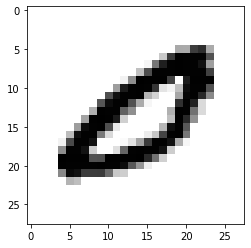

In [9]:
plt.imshow(x[0][0], cmap='gray_r')

## FNN autoencoder

In [10]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            nn.Linear(64, 12), nn.ReLU(True),
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12), nn.ReLU(True),
            nn.Linear(12, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
class autoencoder2(nn.Module):
    def __init__(self):
        super(autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256), nn.ReLU(True),
            nn.Linear(256, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            nn.Linear(64, 32), nn.ReLU(True),
            nn.Linear(32, 16), nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32), nn.ReLU(True),
            nn.Linear(32, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 256), nn.ReLU(True),
            nn.Linear(256, 784), nn.Tanh())
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
learning_rate = 1e-3

In [14]:
model = autoencoder().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [16]:
x, y = next(iter(train_dl))
x = x.float().cuda()

In [17]:
x = x.reshape(x.shape[0], -1)
pred = model(x)
pred.shape

torch.Size([5, 784])

In [18]:
F.mse_loss(pred, x).item()

0.9351300597190857

## Metric: accuracy

In [16]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.cuda().float().reshape(batch, -1)
            pred = model(x)
            loss = F.mse_loss(pred, x)
            sum_loss += batch*(loss.item())
            total += batch
    
    return sum_loss/total

In [21]:
model = autoencoder().cuda()
val_metric(model, valid_dl)

0.9314303716421127

## Training functions

In [17]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [19]:
def train_with_precond(model, train_dl, valid_dl, optimizer, epochs = 5, pre_cond=False):
    idx = 0
    prev_val_auc = 0.0
    for epoch in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float().reshape(batch, -1)
            out = model(x)
            loss = F.mse_loss(out, x)
            optimizer.zero_grad()
            loss.backward()
            if pre_cond:
                preconditioner.step()
            optimizer.step()
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f " % (train_loss, val_loss))
        if epoch % 10 == 0:
            path = '{}/models/autoencoder2_epoch{}.pth'.format(PATH, epoch)
            save_model(model, path)
            
    return sum_loss/total

## Training autoencoders

In [14]:
batch_size = 200
train_dl = DataLoader(train_ds, batch_size=batch_size,  shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=1000)

In [29]:
learning_rate = 1e-3

In [30]:
model = autoencoder().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
train_with_precond(model, train_dl, valid_dl, optimizer, epochs = 100)

train_loss 0.270 val_loss 0.212 
train_loss 0.199 val_loss 0.187 
train_loss 0.180 val_loss 0.173 
train_loss 0.169 val_loss 0.166 
train_loss 0.163 val_loss 0.161 
train_loss 0.159 val_loss 0.158 
train_loss 0.156 val_loss 0.155 
train_loss 0.153 val_loss 0.152 
train_loss 0.151 val_loss 0.150 
train_loss 0.149 val_loss 0.148 
train_loss 0.147 val_loss 0.146 
train_loss 0.145 val_loss 0.145 
train_loss 0.144 val_loss 0.144 
train_loss 0.143 val_loss 0.143 
train_loss 0.141 val_loss 0.141 
train_loss 0.140 val_loss 0.140 
train_loss 0.139 val_loss 0.139 
train_loss 0.138 val_loss 0.139 
train_loss 0.138 val_loss 0.137 
train_loss 0.137 val_loss 0.137 
train_loss 0.136 val_loss 0.136 
train_loss 0.135 val_loss 0.136 
train_loss 0.135 val_loss 0.135 
train_loss 0.134 val_loss 0.134 
train_loss 0.133 val_loss 0.134 
train_loss 0.133 val_loss 0.134 
train_loss 0.133 val_loss 0.133 
train_loss 0.132 val_loss 0.133 
train_loss 0.132 val_loss 0.132 
train_loss 0.131 val_loss 0.132 
train_loss

0.12166002136965592

In [21]:
learning_rate = 1e-3
model = autoencoder2().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
train_with_precond(model, train_dl, valid_dl, optimizer, epochs = 100)

train_loss 0.267 val_loss 0.213 
train_loss 0.189 val_loss 0.164 
train_loss 0.154 val_loss 0.146 
train_loss 0.140 val_loss 0.135 
train_loss 0.130 val_loss 0.126 
train_loss 0.121 val_loss 0.115 
train_loss 0.112 val_loss 0.108 
train_loss 0.107 val_loss 0.105 
train_loss 0.103 val_loss 0.101 
train_loss 0.101 val_loss 0.098 
train_loss 0.099 val_loss 0.098 
train_loss 0.097 val_loss 0.095 
train_loss 0.096 val_loss 0.095 
train_loss 0.094 val_loss 0.094 
train_loss 0.093 val_loss 0.092 
train_loss 0.092 val_loss 0.091 
train_loss 0.091 val_loss 0.092 
train_loss 0.090 val_loss 0.089 
train_loss 0.089 val_loss 0.089 
train_loss 0.088 val_loss 0.089 
train_loss 0.087 val_loss 0.087 
train_loss 0.086 val_loss 0.086 
train_loss 0.085 val_loss 0.085 
train_loss 0.084 val_loss 0.084 
train_loss 0.083 val_loss 0.083 
train_loss 0.082 val_loss 0.082 
train_loss 0.081 val_loss 0.081 
train_loss 0.080 val_loss 0.081 
train_loss 0.080 val_loss 0.079 
train_loss 0.079 val_loss 0.079 
train_loss

0.06068866500010093

## Visualizing results

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_figures(x, x_hat, ncols=6):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axs = plt.subplots(ncols=ncols, nrows=2, figsize=(15, 4))
    plt.setp(axs, xticks=[], yticks=[])
    for i in range(ncols):
        axs[0, i].imshow(x[i], cmap='Greys')
        axs[1, i].imshow(x_hat[i], cmap='Greys')
    axs[0, 0].set_title('Actuals', loc="left", size=25)
    axs[1, 0].set_title('Predictions', loc="left", size=25)
    plt.tight_layout() # optional

In [24]:
model = autoencoder().cuda()
load_model(model, PATH/"models/autoencoder_epoch90.pth")

In [25]:
x, _ = next(iter(valid_dl))
x1 = x.cuda().float().reshape(x.shape[0], -1)
x_hat = model(x1)
x_hat = x_hat.cpu().detach().numpy()
x_hat = x_hat.reshape(x.shape[0], 28, 28)
x = x[:, 0].numpy()

TypeError: 'NoneType' object is not callable

In [ ]:
x.shape, x_hat.shape 

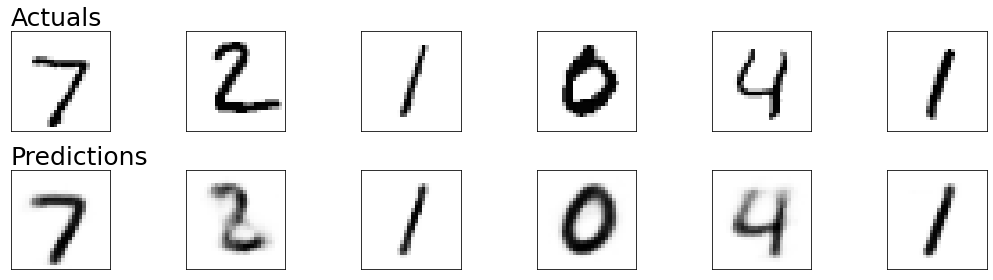

In [50]:
plot_figures(x, x_hat)

In [ ]:
model2 = autoencoder2().cuda()
model2 = load_model(model2, PATH/"models/autoencoder2_epoch90.pth")

In [ ]:
x_hat2 = model(x1)
x_hat2 = x_hat.cpu().detach().numpy()
x_hat2 = x_hat.reshape(x.shape[0], 28, 28)

In [ ]:
plot_figures(x, x_hat2)